In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import arange, array, exp
from tqdm import tqdm

### Slanted Plume Model
- Model identical to the one descirbed by Okubo and Levin (1989) (access here: https://biomath.usu.edu/files/7pd.pdf), but developed independently
- Constants table from either the ICE911 paper, or typical plume model conditions describe here: https://www.eng.uwo.ca/people/esavory/Gaussian%20plumes.pdf
- Plume illustration:
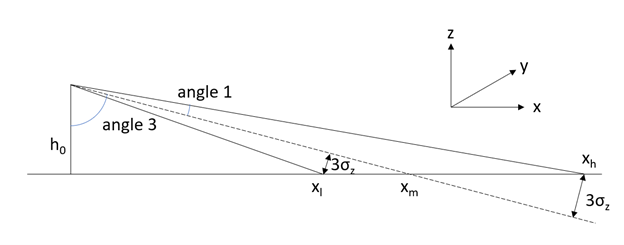

In [12]:
# Define constants. all units in SI
q = 1 #emission rate, kg/s
#u = 5 #wind speed, m/s
h0 = 60 #stack height, m
z0 = 2e-4 #aerodynamic roughness, m
srho = 125 # particle material density, kg/m3
smass = 0.3e9 #total mass of particles released, kg

dsigma = 3 # number of standard deviatios to calculate the plume range over

#turbulent wind speed fluctuations
iy = 0.88/(np.log(h0/z0)-1)
print(iy)
iz = 0.5/(np.log(h0/z0)-1)
print(iz)

# alternative values for volcanic ash here: https://sci-hub.se/10.1016/S0377-0273(97)00037-1
#eddy diffusivity: Kz = 10 m2/s, Ky = 2e4 m2/s; 

0.07578668895291345
0.04306061872324628


### Set up utility functions to calculate particle concentrations

In [13]:
r = 32.5e-6
u = 10
xedge(r)

[458.50051909122726, 36328.83215672162]

In [15]:
def stokev(r):
    #returns stoke velocity for glass spheres of radius r
    return 2/9*(125-1.29)/1.723e-5*9.8*r**2

def delx(x,r):
    #returns the deviation of the centerline as a function of position x and size r
    return x/u*stokev(r)

def xedge(r):
    #returns the lower edge at dsigma and the center line position of the plume on the ground and 
    angle3 = np.arctan(u/stokev(r))
    angle1 = np.arctan(dsigma*iz)
    xl = h0*np.tan(angle3-angle1)
    xm = h0*np.tan(angle3)#+angle1)
    return [xl, xm]


# standard deviation of the plume conc. along y
def sigmay_val(x): return iy*x
# standard deviation of the plume conc. along x
def sigmaz_val(x): return iz*x

def xrel_calc(x,r):
    #project the plume coordinate to absolute. xrel is x position along plume center, zrel is z position in plume coord
    angle3 = np.arctan(u/stokev(r))
    anglex = np.arctan(x/h0)
    angle1 = angle3-anglex
    xrel = x*np.cos(angle1)/np.sin(anglex)
    zrel = x*np.sin(angle1)/np.sin(anglex)
    return xrel,np.abs(zrel)

def conc_g(x, y, r, z=0):
    #returns concentration (kg/m3) at the ground level at position x, y, z for particles with size r
    #[xl,xm] = xedge(r)
#    if x>xm: 
#        x = xm-(x-xm)
    xrel,zrel = xrel_calc(x,r)
    sigmay = sigmay_val(xrel)
    sigmaz = sigmaz_val(xrel)
    c = q/u/np.pi/sigmay/sigmaz*np.exp(-y**2/2/sigmay**2)*np.exp(-(z-(h0-delx(x,r)))**2/2/sigmaz**2)
    return c


### Extrapolate albedo as a function of particle layer thickness. 
- Showing linear extrapolation and Logistic function fitting
- Currently using a mixture of the logistic function fit and linear function fit

C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead


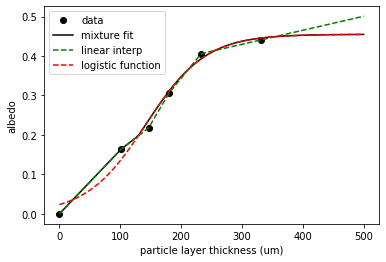

In [16]:
thk = [0,101.55,146.7,180.7,233,331]
albedo = [0, 0.163870968,0.218064516,0.307096774,0.405806452,0.440645161]

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return array(list(map(pointwise, array(xs))))

    return ufunclike

def func(x, a, b, k): # the logistic function form
    return a/(1+b*np.exp(-k*x))
popt, pcov = curve_fit(func, np.hstack([0.1,thk[1:]]), np.hstack([0,albedo[1:]]))#, bounds=(0, [0.2, 0.2]))

def albedo_func(x):
    x = np.array(x)
    alpha_temp = np.zeros(len(x))
    alpha_temp[x<=131.3] = f_x(x[x<=131.3])
    alpha_temp[x>131.3] = func(x[x>131.3], *popt)
    return alpha_temp


f = interp1d(thk, albedo, kind='slinear')
f_x = extrap1d(f)
xnew = np.linspace(0, 500, 100)
plt.figure()
plt.plot(thk,albedo,'ko')
plt.plot(xnew, albedo_func(xnew),'k-')
plt.plot(xnew, f_x(xnew), 'g--')
plt.plot(xnew, func(xnew, *popt), 'r--')

plt.xlabel('particle layer thickness (um)')
plt.ylabel('albedo')
plt.legend(['data','mixture fit','linear interp', 'logistic function'])

### Calculate distribution of spheres on a grid
- The grid range is defined by assuming that any grid with an average particle thickness of <0.1 nm is empty
- The grid resolution was tested so that changing the the resolution does not change the resulting plume shape estimate
- Particle distribution from the half of the plume closest to the boat (between xl and xm as shown in plot in the intro cell) is calculated first. The mass distribution is then normalized using this result. The other half of the model is then treated. 


In [14]:
#helper functions to calculate particle distribution on a grid
def conc2thk(r, conc):
    #return a layer thickness according to the conctration of particles here
    #conc in kg/m2
    pdensity = np.sqrt(2)/6*np.pi #spatial density assuming closest packing
    thk = conc/srho/pdensity
    return thk

def dens_calc(xcoord, ycoord, r):
    #return a particle density matrix (arbitratry units)
    xgrid = len(xcoord); ygrid = len(ycoord)
    dens = np.zeros([xgrid,ygrid])
    for i in range(xgrid):
        for j in range(ygrid):
            dens[i,j] = conc_g(xcoord[i],ycoord[j],r)
    dens[np.isnan(dens)] = 0
    return dens


def dens2conc(dens,xcoord,ycoord):
    # convert a unitless density matrix to a particle density matrix in kg/m2
    garea = (xcoord[1]-xcoord[0])*(ycoord[1]-ycoord[0]) #grid area in m2
    dens_mass = garea*np.nansum(dens)
    calfac = smass/dens_mass
    dens = dens*calfac # normalize particle mass so it sums to the total mass distributed
    return dens, calfac

def thk2mass(thk, xsize, ysize):
    #returns total mass integrated over the grid area for a thk matrix (m)
    pdensity = np.sqrt(2)/6*np.pi
    
    return thk*xsize*ysize*pdensity*srho

def gridrange(ctthk = 1e-6):
    #return range of grid with a thk cutoff of ctthk (m) by a coarse grid search
    # search a large area with a coarse grid
    n = 201
    xrng = np.array([0,1000]); yrng = np.array([-50,50])
    xgrid = n; ygrid = n
    
    xcoord = np.linspace(xrng[0],xrng[1],xgrid)
    ycoord = np.linspace(yrng[0],yrng[1],ygrid)
    
    dens = dens_calc(xcoord, ycoord)
    dens,calfac = dens2conc(dens,xcoord,ycoord)
    dens = conc2thk(r,dens)
    dens[dens<ctthk] = 0; 
    border_idx = np.nonzero(dens)
    xmax = xcoord[max(border_idx[0])]
    ymin = ycoord[min(border_idx[1])]; ymax = ycoord[max(border_idx[1])]
    return xmax+np.ptp(xcoord)/xgrid/2, ymin-np.ptp(ycoord)/ygrid/2, ymax+np.ptp(ycoord)/ygrid/2

def thk_calc(n,xmin, xmax,ymin,ymax, calfac = 0):
    #returns the layer thickness over a grid covering [0,xmax] and [ymin,ymax] with x/y resolution of n
    xgrid = n; ygrid = n
    xrng = np.array([xmin,xmax]); yrng = np.array([ymin,ymax])

    xcoord = np.linspace(xrng[0],xrng[1],xgrid)#+xmax/xgrid/2
    ycoord = np.linspace(yrng[0],yrng[1],ygrid)#+(ymax-ymin)/ygrid/2

    dens = dens_calc(xcoord, ycoord, r)
    if calfac == 0:
        dens, calfac = dens2conc(dens,xcoord,ycoord)
    else:
        dens = calfac*dens
    dens = conc2thk(r, dens)
    return dens, calfac, xcoord, ycoord

##### super janky implementations below. Pardon the mess

36328.83215672162 13766.228288583034


C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


48120485.63421123
0.4982833553472128
24060242.817105614


C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


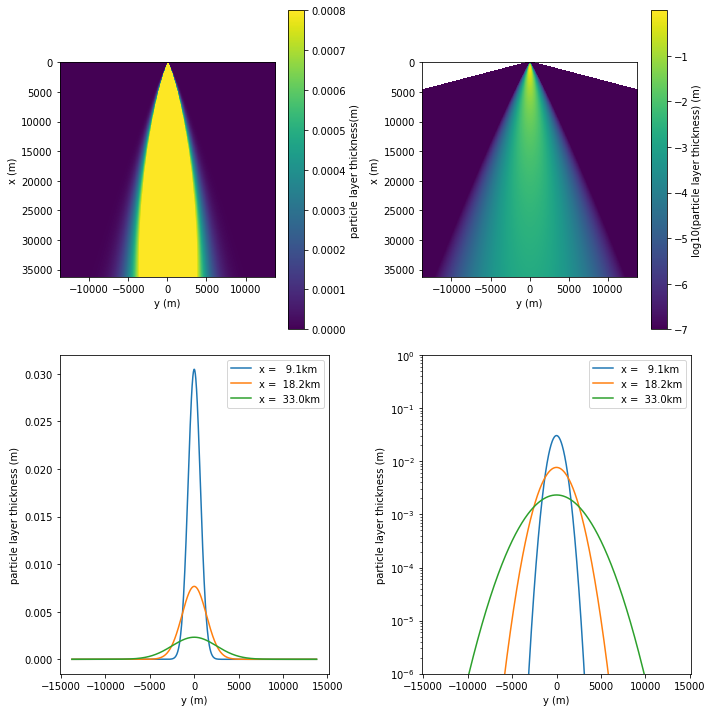

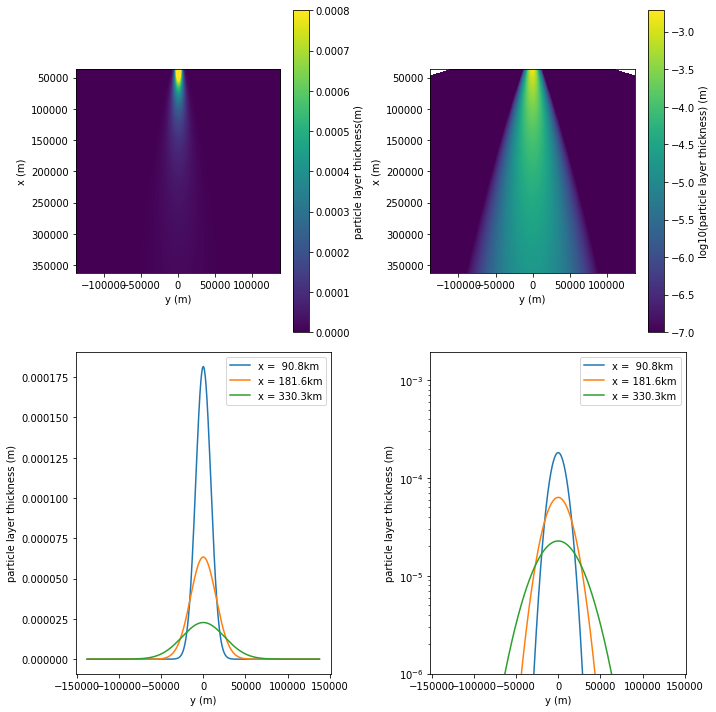

In [19]:
r = 32.5e-6 # particle radius, m
u = 10 #windspeed, m/s

n = 1000 #grid resolution

# #turbulent wind speed fluctuations
# moderately unstable conditions
# iy = 0.3
# iz = 0.12

# #neutral conditions
iy = 0.88/(np.log(h0/z0)-1) #0.0837
iz = 0.5/(np.log(h0/z0)-1) #0.0476

#calculate plume distribution
# define particle size and the grid
(xl, xmax) = xedge(r); xmin = 0
xrel, zrel = xrel_calc(xmax,r)
ymax = sigmay_val(xrel)
ymax = 5*ymax
ymin = -ymax
print(xmax,ymax)

# calculate the first half of the plume
dens,calfac,xcoord,ycoord = thk_calc(n,xmin,xmax,ymin,ymax)
dens = dens/2
print(calfac)
print(np.max(dens)/2)
calfac = calfac/2
print(calfac)
makeplots(dens = dens, ycoord = ycoord)

# get the real full plume distribution
xmin = xmax
xmax = xmax*10
ymin = ymin*10
ymax = ymax*10

dens2,calfac2,xcoord2,ycoord2 = thk_calc(n,xmin,xmax,ymin,ymax,calfac=calfac)
makeplots(dens = dens2,ycoord = ycoord2)


dens10 = dens.copy()
dens10_2 = dens2.copy()
xcoord10=xcoord.copy()
xcoord10_2 = xcoord2.copy()
ycoord10 = ycoord.copy()
ycoord10_2 = ycoord2.copy()

massadd = np.hstack([np.sum(thk2mass(dens,xcoord[1]-xcoord[0],ycoord[1]-ycoord[0]),axis = 1), 
                    np.sum(thk2mass(dens2,xcoord2[1]-xcoord2[0],ycoord2[1]-ycoord2[0]),axis = 1)])
massdensadd = np.hstack([np.sum(thk2mass(dens,xcoord[1]-xcoord[0],ycoord[1]-ycoord[0]),axis = 1)/(xcoord[1]-xcoord[0]), 
                    np.sum(thk2mass(dens2,xcoord2[1]-xcoord2[0],ycoord2[1]-ycoord2[0]),axis = 1)/(xcoord2[1]-xcoord2[0])])
masscumtot = np.cumsum(massadd)
massdenscumtot = np.cumsum(massdensadd)
xadd = np.hstack([xcoord,xcoord2])

xadd10 = xadd.copy()
massdensadd10 = massdensadd.copy()
masscumtot10 = masscumtot.copy()

18164.416078360468 6883.142306958658


C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


29839087.60340197
0.660113337211657
14919543.801700985


C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


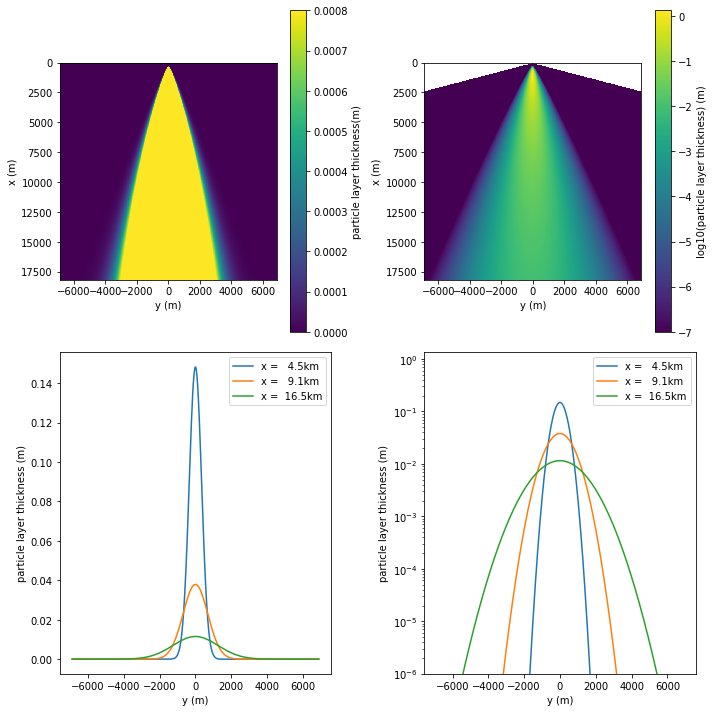

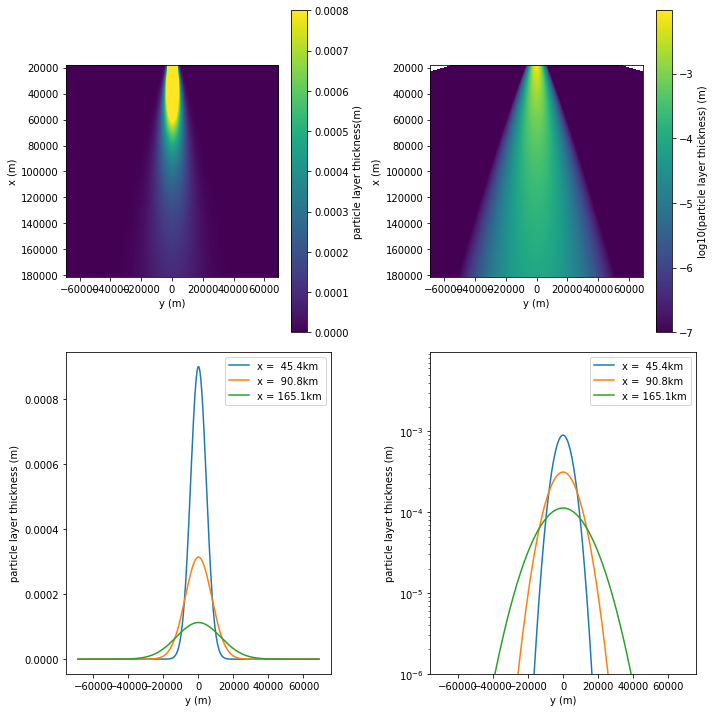

In [20]:
r = 32.5e-6 # particle radius, m
u = 5 #windspeed, m/s

n = 1000 #grid resolution

# #turbulent wind speed fluctuations
# moderately unstable conditions
# iy = 0.3
# iz = 0.12

# #neutral conditions
iy = 0.88/(np.log(h0/z0)-1) #0.0837
iz = 0.5/(np.log(h0/z0)-1) #0.0476

#calculate plume distribution
# define particle size and the grid
(xl, xmax) = xedge(r); xmin = 0
xrel, zrel = xrel_calc(xmax,r)
ymax = sigmay_val(xrel)
ymax = 5*ymax
ymin = -ymax
print(xmax,ymax)

dens,calfac,xcoord,ycoord = thk_calc(n,xmin,xmax,ymin,ymax)
dens = dens/2
print(calfac)
print(np.max(dens)/2)
calfac = calfac/2
print(calfac)
makeplots(dens = dens, ycoord = ycoord)

#calfac = 15939534.737145495 # u = 5 under neutral
# get the real plume distribution
xmin = xmax
xmax = xmax*10
ymin = ymin*10
ymax = ymax*10

dens2,calfac2,xcoord2,ycoord2 = thk_calc(n,xmin,xmax,ymin,ymax,calfac=calfac)
makeplots(dens = dens2,ycoord = ycoord2)

dens5 = dens.copy()
dens5_2 = dens2.copy()
xcoord5=xcoord.copy()
xcoord5_2 = xcoord2.copy()
ycoord5 = ycoord.copy()
ycoord5_2 = ycoord2.copy()


massadd = np.hstack([np.sum(thk2mass(dens,xcoord[1]-xcoord[0],ycoord[1]-ycoord[0]),axis = 1), 
                    np.sum(thk2mass(dens2,xcoord2[1]-xcoord2[0],ycoord2[1]-ycoord2[0]),axis = 1)])
massdensadd = np.hstack([np.sum(thk2mass(dens,xcoord[1]-xcoord[0],ycoord[1]-ycoord[0]),axis = 1)/(xcoord[1]-xcoord[0]), 
                    np.sum(thk2mass(dens2,xcoord2[1]-xcoord2[0],ycoord2[1]-ycoord2[0]),axis = 1)/(xcoord2[1]-xcoord2[0])])
masscumtot = np.cumsum(massadd)
massdenscumtot = np.cumsum(massdensadd)
xadd = np.hstack([xcoord,xcoord2])

xadd5 = xadd.copy()
massdensadd5 = massdensadd.copy()
masscumtot5 = masscumtot.copy()

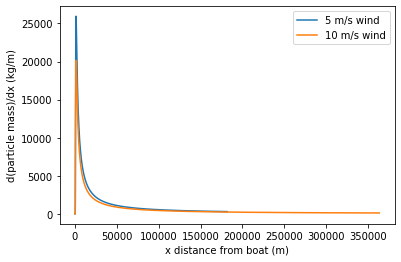

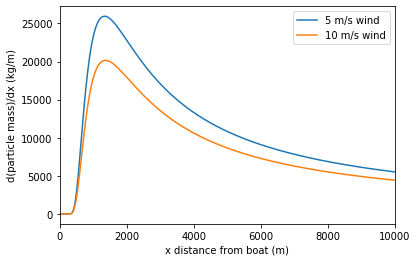

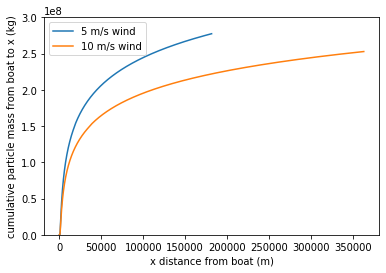

In [21]:
plt.figure()
plt.plot(xadd5,massdensadd5,xadd10,massdensadd10)
plt.xlabel('x distance from boat (m)')
plt.ylabel('d(particle mass)/dx (kg/m)')
plt.legend(['5 m/s wind','10 m/s wind'])

plt.figure()
plt.plot(xadd5,massdensadd5,xadd10,massdensadd10)
plt.xlim([0,10000])
plt.xlabel('x distance from boat (m)')
plt.ylabel('d(particle mass)/dx (kg/m)')
plt.legend(['5 m/s wind','10 m/s wind'])


plt.figure()
plt.plot(xadd5,masscumtot5,xadd10,masscumtot10)
plt.ylim([0,3e8])
plt.xlabel('x distance from boat (m)')
plt.ylabel('cumulative particle mass from boat to x (kg)')
plt.legend(['5 m/s wind','10 m/s wind'])

C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


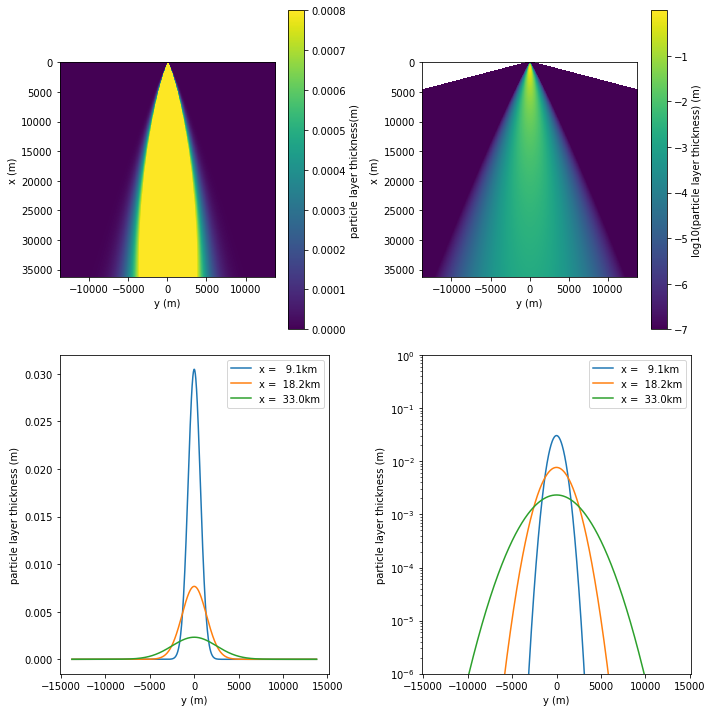

In [18]:
#plot plume distribution

#dens[dens<ctthk] = 0
#linear scale
def makeplots(dens = dens, ycoord = ycoord):
    fig, ax = plt.subplots(2,2,figsize=(10,10))#,constrained_layout=True)
    pos = ax[0,0].imshow(dens, extent=[ymin,ymax,xmax,xmin], vmax = 8e-4)#, vmax = 5e-24)
    ax[0,0].set_aspect((ymax-ymin)/(xmax-xmin))
    cbar = fig.colorbar(pos, ax = ax[0,0])
    cbar.set_label('particle layer thickness(m)')
    ax[0,0].set_xlabel('y (m)')
    ax[0,0].set_ylabel('x (m)')

    #log scale
    #fig, ax = plt.subplots(figsize=(6,6))
    pos = ax[0,1].imshow(np.log10(dens), extent=[ymin,ymax,xmax,xmin], vmin = -7)
    ax[0,1].set_aspect((ymax-ymin)/(xmax-xmin))
    cbar = fig.colorbar(pos,ax = ax[0,1])
    cbar.set_label('log10(particle layer thickness) (m)')
    ax[0,1].set_xlabel('y (m)')
    ax[0,1].set_ylabel('x (m)')


    #plot plume profile at various distances
    prof_dist = [xmax/4,xmax/2,xmax/1.1]
    #plt.figure()
    for d in prof_dist:
        ax[1,0].plot(ycoord, dens[int(d/xmax*n),:])
    #ax[1,0].set_yscale('log')
    ax[1,0].set_xlabel('y (m)')
    ax[1,0].set_ylabel('particle layer thickness (m)')
    ax[1,0].legend(['x = {:5.1f}km'.format(d/1000) for d in prof_dist])

    #plot plume profile along y = 0
    prof_dist = [xmax/4,xmax/2,xmax/1.1]
    #plt.figure()
    for d in prof_dist:
        ax[1,1].plot(ycoord, dens[int(d/xmax*n),:])
    ax[1,1].set_yscale('log')
    ax[1,1].set_xlabel('y (m)')
    ax[1,1].set_ylabel('particle layer thickness (m)')
    ax[1,1].legend(['x = {:5.1f}km'.format(d/1000) for d in prof_dist])
    ax[1,1].set_ylim([1e-6,np.max(dens)*1.01])
    plt.tight_layout()

makeplots()

### calculate plume radiative efficiency
- Define the radiative efficiency as:
    - actual average albedo change based on the plume distribution/ average albedo change assuming a monolayer of particles

In [42]:
iarea = smass/srho/(4/3*np.pi*r**3)*r**2*4 #area the particles would cover under an ideal monolayer distribution
ialbedo = albedo_func([r*2*1e6])

 
try:
    tqdm._instances.clear()
except: 
    pass

def alpha_mat_calc(dens,xcoord,ycoord,idxlim = 1e5):
    garea = (xcoord[1]-xcoord[0])*(ycoord[1]-ycoord[0])
    plume_alpha = 0
    for i in tqdm(range(min(dens.shape[0],idxlim))):
        alpha_val = albedo_func(dens[i,:]*1e6)
        plume_alpha += np.sum(alpha_val)
        if i == 0:
            alpha_mat = alpha_val
        else:
            alpha_mat = np.vstack([alpha_mat,alpha_val])
    return plume_alpha, alpha_mat, garea

# index for x distance away from boat that account pml amount of particle mass
pml = 2.5e8
idxlim5 = np.abs(masscumtot5-pml).argmin()-n
idxlim10 = np.abs(masscumtot10-pml).argmin()-n

# calculate radiative efficiency for 5 m/s wind
plume_alpha, alpha_mat, garea = alpha_mat_calc(dens5, xcoord5, ycoord5)
plume_alpha2, alpha_mat2, garea2 = alpha_mat_calc(dens5_2, xcoord5_2, ycoord5_2, idxlim = idxlim5)
rad_eff = (plume_alpha*garea+plume_alpha2*garea2)/(ialbedo*iarea*pml/smass)
print('the radiative efficiency of the plume is {} for 5 m/s wind, considering {}% of the plume by mass'.format(rad_eff,pml/smass*100))

# calculate radiative efficiency for 10 m/s wind
plume_alpha, alpha_mat, garea = alpha_mat_calc(dens10, xcoord10, ycoord10)
plume_alpha_2, alpha_mat_2, garea_2 = alpha_mat_calc(dens10_2, xcoord10_2, ycoord10_2, idxlim = idxlim10)
rad_eff = (plume_alpha*garea+plume_alpha2*garea_2)/(ialbedo*iarea*pml/smass)
print('the radiative efficiency of the plume is {} for 10 m/s wind, considering {}% of the plume by mass'.format(rad_eff,pml/smass*100))


C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
100%|████████████████████████████████████████████████████████████████████████████████| 564/564 [00:16<00:00, 35.14it/s]


the radiative efficiency of the plume is [0.12424963] for 5 m/s wind, considering 83.33333333333334% of the plume by mass


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:31<00:00, 29.35it/s]


the radiative efficiency of the plume is [0.49303992] for 10 m/s wind, considering 83.33333333333334% of the plume by mass


C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


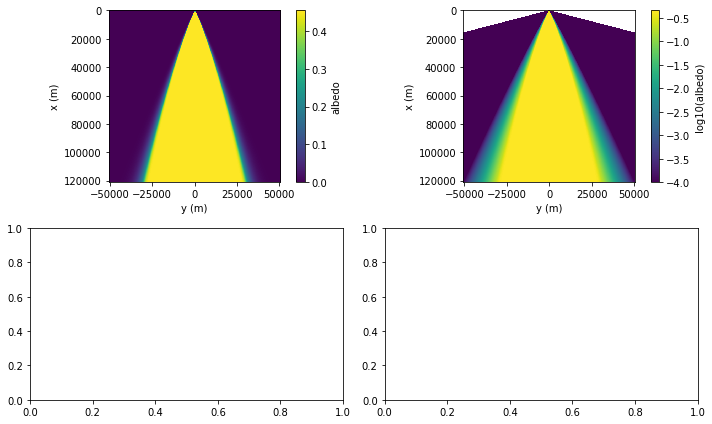

In [97]:
# fig, ax = plt.subplots(2,2,figsize=(10,6))#,constrained_layout=True)
# pos = ax[0,0].imshow(alpha_mat, extent=[ymin,ymax,xmax,0])#, vmax = 0.2)#, vmax = 5e-24)
# ax[0,0].set_aspect((ymax-ymin)/xmax)
# cbar = fig.colorbar(pos, ax = ax[0,0])
# cbar.set_label('albedo')
# ax[0,0].set_xlabel('y (m)')
# ax[0,0].set_ylabel('x (m)')

# #log scale
# #fig, ax = plt.subplots(figsize=(6,6))
# pos = ax[0,1].imshow(np.log10(alpha_mat), extent=[ymin,ymax,xmax,0], vmin = -4)
# ax[0,1].set_aspect((ymax-ymin)/xmax)
# cbar = fig.colorbar(pos,ax = ax[0,1])
# cbar.set_label('log10(albedo)')
# ax[0,1].set_xlabel('y (m)')
# ax[0,1].set_ylabel('x (m)')
# plt.tight_layout()